## Purpose of notebook

We just need to perform segmentation of all the test images, then try using the finetuned model to do prediction

1. Perform segmentation of the test images using SAM2
2. Use finetuned model to perform prediction

In [ ]:
# uncomment as needed when running on drive
# !pip install ultralytics --quiet

In [ ]:
# uncomment as needed when running on drive
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
# change as needed
BASE_FILE_PATH = '/content/drive/MyDrive/Tongue Project (Jia Hao)/Data/train_1'
EXPORT_FILE_PATH = '/content/drive/MyDrive/Tongue Project (Jia Hao)/Data/train_1_segmented'

# optimal thresholds taken from previous model development
OPTIMAL_THRESHOLDS = [0.03, 0.09, 0.64]

# file path for the translated csv file of physician labels
PHYSICIAN_LABELS_FILE = 'physician_1.csv'

In [126]:
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from ultralytics import SAM

import torch
import torch.nn.functional as F
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, DefaultDataCollator, AutoImageProcessor
from datasets import load_dataset

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import os

Preprocess the ground truth labels to put 1 if any position is 1

In [85]:
# read first physician's labels and the images he/she labelled
df = pd.read_csv(PHYSICIAN_LABELS_FILE)

# current model is trained to only detect: Cracks, Red Dots (Petechiae), Toothmarks
# for now, set it such that if any concerned column is 1, we set the label to 1
df['Crack'] = df[['Tongue Cracks - centre', 'Tongue Cracks - back']].apply(lambda x: 1 if any(x == 'present') else 0, axis=1)
df['Red Dots'] = df[['Petechiae - centre', 'Petechiae - sides']].apply(lambda x: 1 if any(x == 'present') else 0, axis=1)
df['Toothmarks'] = df[['Tooth-marks - tip', 'Tooth-marks - sides']].apply(lambda x: 1 if any(x == 'present') else 0, axis=1)

test_df = df[['image_name', 'Crack', 'Red Dots', 'Toothmarks']]

## Perform segmentation as a preprocessing step

Segment the test images by the physician

In [53]:
model = SAM("sam2.1_l.pt")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# print out device we are working on
device

'cuda'

In [54]:
# function to segment an image
def segment(image):
    image_np = np.array(image)

    # Segmentation
    results_pil = model(image_np, points=[[350, 320], [0, 0]], labels=[1, 0])

    # Get the mask from the results
    mask_pil = results_pil[0].masks.data[0].cpu().numpy()

    # Masking
    binary_mask = mask_pil > 0.5
    rgb_mask = np.repeat(binary_mask[:, :, np.newaxis], 3, axis=2)
    segmented_image = image_np * rgb_mask

    return segmented_image

In [56]:
# WARNING: uncomment code only if we need to segment the images, otherwise, we can leave it

segmented_images = []
for row in test_df.iterrows():
  img = cv2.imread(os.path.join(BASE_FILE_PATH, row[1]['image_name']))
  img = Image.fromarray(segment(img))
  # convert into RGB, then append to list
  img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  segmented_images.append(img)


0: 1024x1024 1 0, 1 1, 687.3ms
Speed: 12.8ms preprocess, 687.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 607.5ms
Speed: 19.7ms preprocess, 607.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 672.4ms
Speed: 40.8ms preprocess, 672.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 667.2ms
Speed: 29.4ms preprocess, 667.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 667.7ms
Speed: 34.7ms preprocess, 667.7ms inference, 5.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 618.1ms
Speed: 14.4ms preprocess, 618.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 620.8ms
Speed: 16.5ms preprocess, 620.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 615.5ms
Speed: 20.3ms preprocess, 615.5ms inf

In [57]:
len(segmented_images)

200

In [62]:
# export to google drive so we do not have to re-segment the images next time when running
image_names = test_df['image_name'].tolist()
for i in range(len(segmented_images)):
  segmented_img_rgb = cv2.cvtColor(segmented_images[i], cv2.COLOR_BGR2RGB)
  cv2.imwrite(os.path.join(EXPORT_FILE_PATH, image_names[i]), segmented_img_rgb)

## Load classifier model from checkpoint, perform prediction

In [63]:
model = AutoModelForImageClassification.from_pretrained("e1010101/vit-384-large-patch-tongue-image-segmented")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Lin

In [64]:
processor = AutoImageProcessor.from_pretrained("e1010101/vit-384-large-patch-tongue-image-segmented")
inputs = processor(images=segmented_images, return_tensors="pt").to(device)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [69]:
# perform predictions with model
with torch.no_grad():
    logits = model(**inputs).logits

In [70]:
probabilities = F.sigmoid(logits)

In [79]:
# convert them into model predictions
preds = (probabilities.to('cpu').numpy() > OPTIMAL_THRESHOLDS).astype(int)

In [87]:
# add predictions to another column
test_df.loc[:, ['Cracks_preds', 'Red Dots_preds', 'Toothmarks_preds']] = preds
test_df.head()

,image_name,Crack,Red Dots,Toothmarks,Cracks_preds,Red Dots_preds,Toothmarks_preds
0,CC_1.jpg,0,0,0,0,1,0
1,CC_100.jpg,1,0,1,0,0,1
2,CC_1001.jpg,1,0,1,1,1,1
3,CC_1002.jpg,1,0,0,1,0,0
4,CC_101.jpg,1,0,1,1,1,1


## Evaluate model performance on physician-labelled data

In [94]:
report = classification_report(
    test_df[['Crack', 'Red Dots', 'Toothmarks']],
    test_df[['Cracks_preds', 'Red Dots_preds', 'Toothmarks_preds']],
    target_names=['Crack', 'Red Dots', 'Toothmarks'],
    zero_division = 0
)
print(report)

              precision    recall  f1-score   support

       Crack       0.97      0.76      0.85       119
    Red Dots       0.13      0.91      0.23        22
  Toothmarks       0.85      0.89      0.87       129

   micro avg       0.59      0.84      0.69       270
   macro avg       0.65      0.86      0.65       270
weighted avg       0.84      0.84      0.81       270
 samples avg       0.57      0.74      0.62       270



In [128]:
# helper function to plot confusion matrix
def plot_confusion_matrix_for_class(y_true, y_pred, class_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not ' + class_name, class_name])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.show()

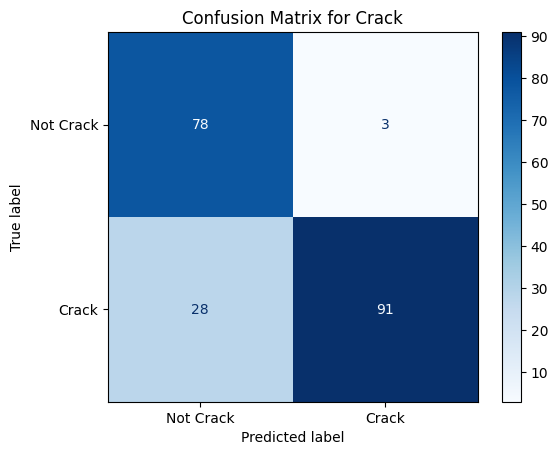

In [127]:
plot_confusion_matrix_for_class(test_df['Crack'], test_df['Cracks_preds'], 'Crack')

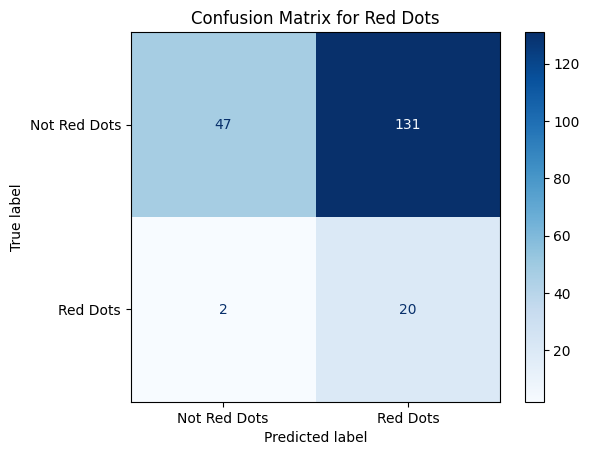

In [123]:
plot_confusion_matrix_for_class(test_df['Red Dots'], test_df['Red Dots_preds'], 'Red Dots')

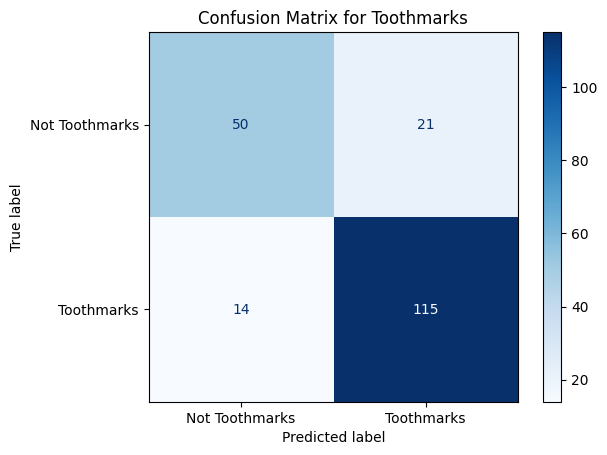

In [124]:
plot_confusion_matrix_for_class(test_df['Toothmarks'], test_df['Toothmarks_preds'], 'Toothmarks')

In [129]:
cracks_acc = accuracy_score(test_df['Crack'], test_df['Cracks_preds'])
dots_acc = accuracy_score(test_df['Red Dots'], test_df['Red Dots_preds'])
toothmarks_acc = accuracy_score(test_df['Toothmarks'], test_df['Toothmarks_preds'])

print(f"Accuracy for cracks: {cracks_acc}")
print(f"Accuracy for red dots: {dots_acc}")
print(f"Accuracy for toothmarks: {toothmarks_acc}")

Accuracy for cracks: 0.845
Accuracy for red dots: 0.335
Accuracy for toothmarks: 0.825


- Poor performance for red dots likely due to under-representation of the red-dots in the test set, will need more data to verify this.

- Model's prediction results for cracks and toothmarks seem to be acceptable, although it may have worsened.

- We need to verify if there is any data leak between the original training data for the model and the physician-labelled data to confirm if the model is really performing well.

### Additional check by performing classification with test images from the model's dataset

In [96]:
dataset = load_dataset("e1010101/tongue-images-384-segmented-augmented")

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [107]:
test_dataset = dataset['test']
test_images = []
for row in test_dataset:
  image = row['image']
  test_images.append(image)

inputs = processor(images=test_images, return_tensors="pt").to(device)

In [105]:
test_labels = []
for row in test_dataset:
  test_labels.append(row['labels'])

In [109]:
with torch.no_grad():
    logits = model(**inputs).logits

probabilities = F.sigmoid(logits)

In [110]:
preds = (probabilities.to('cpu').numpy() > OPTIMAL_THRESHOLDS).astype(int)

In [116]:
test_labels = np.array(test_labels)
preds = np.array(preds)

report = classification_report(
    test_labels,
    preds,
    zero_division = 0,
    target_names=['Crack', 'Red Dots', 'Toothmarks']
)
print(report)

              precision    recall  f1-score   support

       Crack       0.90      0.98      0.94        48
    Red Dots       0.76      0.95      0.85        58
  Toothmarks       0.82      0.79      0.81        68

   micro avg       0.82      0.90      0.86       174
   macro avg       0.83      0.91      0.86       174
weighted avg       0.82      0.90      0.86       174
 samples avg       0.75      0.81      0.75       174



Managed to achieve exactly the same results with original model's test data, so we have not wrongly used the model